# Experimental Quantum Generative Adversarial Networks for Image Generation
A paper by Huang et al.

In [1]:
import jax.config
jax.config.update('jax_enable_x64', True)
import jax
import jax.numpy as jnp
import pennylane as qml
import quantumgan as gan
import matplotlib.pyplot as plt
import optax
from tqdm.notebook import tqdm
from helpers import *

key = jax.random.PRNGKey(1234)

## Batch GAN

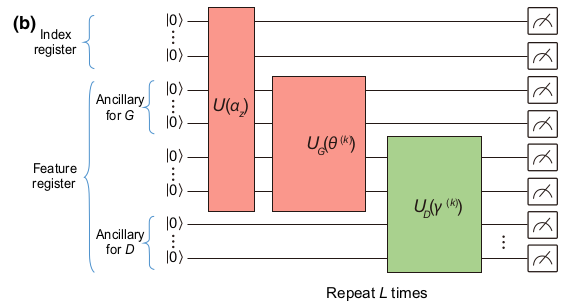

### Dataset

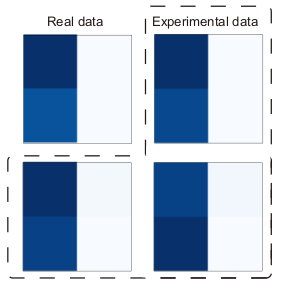

$$\mathbf{x}\in\mathbb{R}^{2\times 2}$$
$$\mathbf{x}_{00}\sim\text{unif}(0.4,0.6)$$
$$\mathbf{x}_{10}=1-\mathbf{x}_{0i}$$
$$\mathbf{x}_{01,11}=0$$

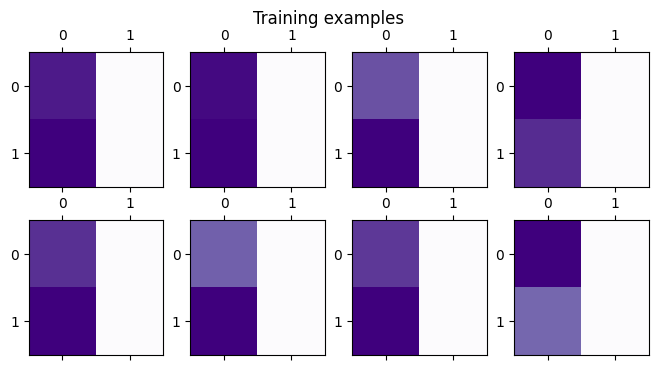

In [2]:
data_key, key = jax.random.split(key)
def generate_data(batch):
    global data_key
    k, data_key = jax.random.split(data_key)
    d = jnp.zeros((batch, 4))
    d_noise = jax.random.uniform(k, (batch,), jnp.float32, 0.4, 0.6)
    d = d.at[:,0].set(d_noise)
    d = d.at[:,2].set(1-d_noise)
    return d

_ = grid_imshow('Training examples', 2, 4, 2, 2, generate_data(8).reshape((2,4,2,2)))
plt.show()
plt.close()

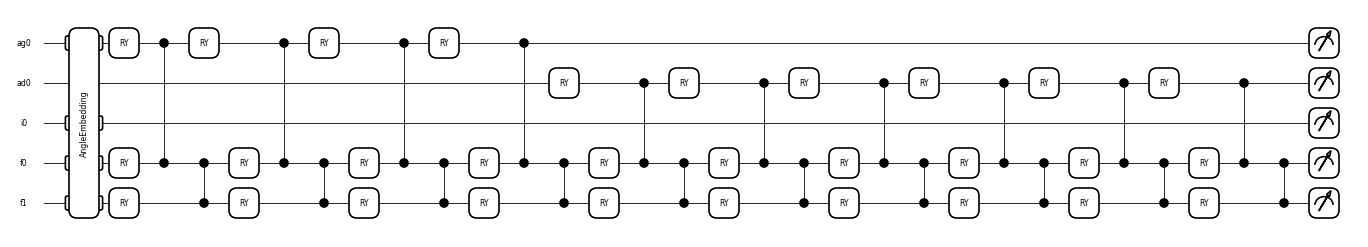

In [3]:
bar_gan = gan.BatchGAN(4, 1, 4, 1, 6, index_qubits=1)
init_key, key = jax.random.split(key)
fig, ax = bar_gan.draw(*bar_gan.init_params(key))
fig.set_dpi(40)
plt.show()
plt.close()

In [4]:
gen_optimizer = optax.sgd(0.05)
dis_optimizer = optax.sgd(0.001)

def train(iters):
    global key
    gen_params, dis_params = bar_gan.init_params(key)

    gen_s = gen_optimizer.init(gen_params)
    dis_s = dis_optimizer.init(dis_params)
    
    checkpoints = []
    g_loss_history = []
    d_loss_history = []
    
    @jax.jit
    def step(gen_params, dis_params, gen_s, dis_s, latent, example):
        assert example.shape == (1, bar_gan.indices, bar_gan.features), f"unexpected example.shape: {example.shape}"
        g_loss, g_grad = jax.value_and_grad(bar_gan.gen_loss)(gen_params, dis_params, latent, example)
        d_loss, d_grad = jax.value_and_grad(bar_gan.dis_loss)(dis_params, gen_params, latent, example)
        g_updates, gen_s = gen_optimizer.update(g_grad, gen_s, gen_params)
        d_updates, dis_s = dis_optimizer.update(d_grad, dis_s, dis_params)
        gen_params = optax.apply_updates(gen_params, g_updates)
        dis_params = optax.apply_updates(dis_params, d_updates)
        return gen_params, dis_params, gen_s, dis_s, g_loss, d_loss
    
    for i in tqdm(range(iters)):
        example = generate_data(bar_gan.indices).reshape(1, bar_gan.indices, bar_gan.features)
        latent_key, key = jax.random.split(key)
        latent = bar_gan.gen_latent(latent_key, 1)
        gen_params, dis_params, gen_s, dis_s, g_loss, d_loss = step(
            gen_params, dis_params, gen_s, dis_s, latent, example
        )
        if i % int(iters/100) == 0 or i == iters-1:
            g_loss_history.append((i, g_loss))
            d_loss_history.append((i, d_loss))
        if i % int(iters/10) == 0 or i == iters-1:
            checkpoints.append(gen_params)
            print(f'{i+1:5}/{iters} gen: {g_loss:5.4f} dis: {d_loss:5.4f}')
    
    gen_params
    return gen_params, dis_params, checkpoints, g_loss_history, d_loss_history

In [5]:
gen_params, dis_params, checkpoints, g_loss_history, d_loss_history = train(5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

    1/5000 gen: 0.7899 dis: 0.4177
  501/5000 gen: 0.0816 dis: 1.7629
 1001/5000 gen: 0.6640 dis: 0.7063
 1501/5000 gen: 0.6800 dis: 0.6927
 2001/5000 gen: 0.6893 dis: 0.6916
 2501/5000 gen: 0.6910 dis: 0.6933
 3001/5000 gen: 0.6902 dis: 0.6939
 3501/5000 gen: 0.6885 dis: 0.6941
 4001/5000 gen: 0.6943 dis: 0.6924
 4501/5000 gen: 0.6918 dis: 0.6936
 5000/5000 gen: 0.6916 dis: 0.6922


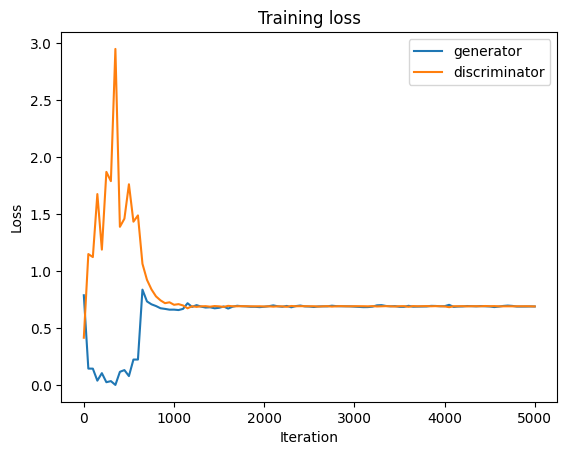

In [6]:
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot([i for i, _ in g_loss_history], [l for _, l in g_loss_history], label='generator')
plt.plot([i for i, _ in d_loss_history], [l for _, l in d_loss_history], label='discriminator')
plt.legend()
plt.show()
plt.close()

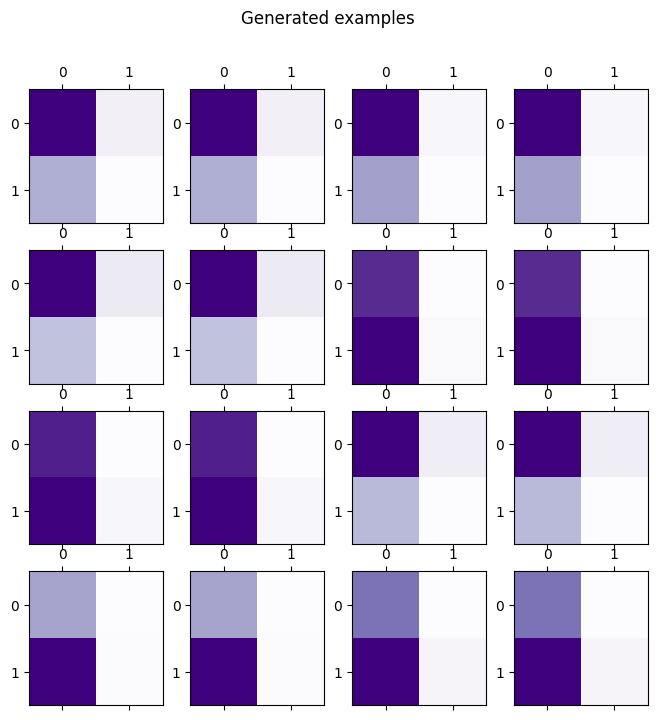

In [7]:
gen_key, key = jax.random.split(key)
d = bar_gan.generate(gen_params, gen_key, 8).reshape(4,4,2,2)
_ = grid_imshow('Generated examples', 4, 4, 2, 2, d)
plt.show()
plt.close()

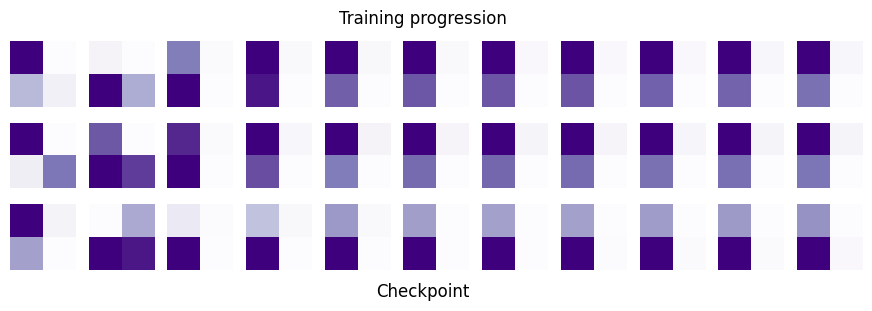

In [8]:
n_samples = 3

gen_key, key = jax.random.split(key)
fig, ax = plt.subplots(n_samples, len(checkpoints), figsize=(len(checkpoints), n_samples))
fig.suptitle('Training progression')
fig.supxlabel('Checkpoint')
for i, checkpoint in enumerate(checkpoints):
    for j, im in enumerate(bar_gan.generate(checkpoint, key, n_samples)[:,0,:].reshape((n_samples,2,2))):
        ax[j,i].matshow(im, cmap='Purples')
        ax[j,i].set_axis_off()
plt.show()
plt.close()